# TP 3  : Graph Neural Networks Architecture

**Théo Rudkiewicz, Cyriaque Rousselot**

# TUTORIAL

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [2]:
# ########## INSTALL TORCH GEOMETRIC ##################
# # https://pytorch-geometric.readthedocs.io/en/latest/
# #####################################################
# import torch


# def format_pytorch_version(version):
#     return version.split("+")[0]


# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)


# def format_cuda_version(version):
#     return "cu" + version.replace(".", "")


# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

/Users/matthieuneau/Library/Caches/pypoetry/virtualenvs/practice-labs-lU_vlk8p-py3.12/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/matthieuneau/Library/Caches/pypoetry/virtualenvs/practice-labs-lU_vlk8p-py3.12/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <4A3195B8-9E71-3AE7-AE80-DBA66ADAC535> /Users/matthieuneau/Library/Caches/pypoetry/virtualenvs/practice-labs-lU_vlk8p-py3.12/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/matthieuneau/Library/Caches/pypoetry/virtualenvs/practice-labs-lU_vlk8p-py3.12/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node has:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct nodes' labels**.

**It is a node (multi-label) classification task** (trained using supervised learning, with labels to be predicted for each node). 

For your curiosity, more detailed information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [4]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)
print(train_dataset[0].y)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121
tensor([[1., 0., 0.,  ..., 1., 1., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-label) classification task, computing 121 features (for each node).

In [180]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [9]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Next we construct the function to train the model.

In [17]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):
    epoch_list = []
    scores_list = []
    loss_per_epoch = []

    for epoch in range(max_epochs):
        model.train()
        losses = []
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            loss = loss_fcn(logits, train_batch_device.y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        loss_per_epoch.append(loss_data)
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 10 == 0:
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list, loss_per_epoch

Epoch 00001 | Loss: 0.5832
F1-Score: 0.3920
Epoch 00002 | Loss: 0.5557
Epoch 00003 | Loss: 0.5483


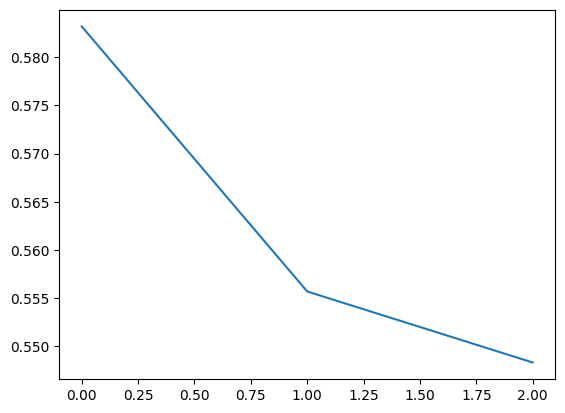

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GAT

class StudentModel(GAT):
    def __init__(self):
        super().__init__(in_channels=50, hidden_channels=256, num_layers=4, out_channels=121, act='ELU', heads=4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StudentModel()
loss_fcn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

max_epochs = 3
epoch_list, loss_per_epoch = train(model, loss_fcn=loss_fcn, device=device, optimizer=optimizer, max_epochs=max_epochs, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

torch.save(model.state_dict(), 'models/model.pth')

plt.plot(range(max_epochs), loss_per_epoch)

Let's train this model !

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

max_epochs = 200

basic_model = BasicGraphModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)
loss_fcn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

# epoch_list, basic_model_scores = train(
#     basic_model,
#     loss_fcn,
#     device,
#     optimizer,
#     max_epochs,
#     train_dataloader,
#     val_dataloader,
# )


Device:  cpu


Let's evaluate the performance of this basic model

In [10]:
# ### F1-SCORE ON VALID DATASET
# score_valid = evaluate(basic_model, loss_fcn, device, val_dataloader)
# print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


# ### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
# def plot_f1_score(epoch_list, scores):
#     plt.figure(figsize=[10, 5])
#     plt.plot(epoch_list, scores)
#     plt.title("Evolution of F1-Score w.r.t epochs")
#     plt.ylim([0.0, 1.0])
#     plt.show()


# plot_f1_score(epoch_list, basic_model_scores)

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide at least 4 files : 
1. This Notebook
2. `class_model_gnn.py`
3. `model.pth` (the file **must be of size less than 50Mo** but 20Mo should be enough to get a very good model)
4. `conv_as_message_passing.py`

If the function you defined passes all the tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear, short and __bold font__ answers.  

> Question 1 : Design, build and train a model with a F1-score higher than 93% on validation set (**HINT :** https://arxiv.org/pdf/1710.10903.pdf).


 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `class_model_gnn.py` containing the class inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `model.pth` file : the model weights
 
 We will  test your model on final F1-Score on a test set. You must not use the test set for hyperparameter training.
 
Intermediate question : 

 Provide the script for training, and a plot of the training loss.  

In [14]:

# Save the model
torch.save(model.state_dict(), "model.pth")


# This is the part we will run in the inference to grade your model
# Load the model
model = GAT()  # !  Important : No argument
model.load_state_dict(torch.load("model.pth", weights_only=True))
model.eval()
print("Model loaded successfully")


TypeError: BasicGNN.__init__() missing 3 required positional arguments: 'in_channels', 'hidden_channels', and 'num_layers'

## Conv 2D as Message Passing Neural Network


## Introduction

The use of graph is a way to structure data by adding neighborhood information between features. This then allows to do operations on the data that are local to each node and its neighbors. This is the main idea behind Graph Neural Networks (GNNs). [`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) is a library compatible with PyTorch that allows to easily implement GNNs. The most general structure is the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class that is then used as a base for more specific GNNs as seen in the course ([Graph Convolutional Networks](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) or [Graph AttenTion Convolution](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)).

On the other hand, you already know an operation that uses the structure of the data to do local operations: the convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). One can see the convolution as a specific case of the message passing neural network. The goal of this notebook is to show how to use the `MessagePassing` class to implement a convolutional neural network.
You will be asked to implement 3 functions. You should give back those three functions in a file named `conv_as_message_passing.py`. These functions will then be automatically tested. So be sure to respect the function signature and the function name.


## Assumptions

To make the implementation easier we will make some assumptions:
- the input is a single image (batch size of 1) of size 'C x H x W'
- the convolution will be a 3x3 kernel with stride 1 and padding 1.

You may also assume that the Conv2D layer has no bias but it will be slightly penalized in the grading.

Bonus points will be given if you can handle the cases that are not covered by those assumptions.


## Questions

### Question 2

> Using the formalism used in the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) documentation (and on [wikipedia](https://en.wikipedia.org/wiki/Graph_neural_network#Message_passing_layers) with sligthly different notations), explain how theorically you can simulate a 2D convolution using the `MessagePassing` formalism. This may include a pre-processing step to transform the image into a graph and then a post-processing step to transform the graph back into an image. (:warning: Those steps should be independent of the parameters of the convolution, but not necessarily from the hyper-parameters.)
$$\mathbf{x}_{i}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$


HINT : It is possible to do it with the following $\gamma$ : 

$$ \gamma_\Theta : x,y \mapsto y $$


The idea is to consider an image as a graph where each pixel is a node and its neighbors are all the pixels covered by the convolution kernel. More specifically, for in image of size C x H x W and kernels of size 3x3, the neighborhood of x_ij(k) consists in the 9 pixels square centered at x_ij(k) for all the filters in the image (including xij itself). Therefore a node has a total of 3x3xK neighbors. 

To handle the border cases, we can reuse the traditional idea of zero padding.

Then we can use the suggested function $$ \gamma_\Theta : x,y \mapsto y + b_\theta $$

where $b_\theta$ represents the bias of the layer

The aggragation function to use is the sum

For the function $$\phi_\Theta : x_i, x_j, e_{j,i} \mapsto e_{j,i}*x_j$$


In [12]:
import torch
import torch_geometric

### Question 3

> Implement the pre-processing function, you can use the follwing code skeleton (you may change the output type, it is just a strong suggestion):

In [ ]:
from torchvision.datasets import MNIST
from torch_geometric.data import Data
import torchvision.io as io

dataset = MNIST('./MNIST', download=True)
img, label = dataset[0]
img.save('mnist_sample.png')


def image_to_graph(
    image: torch.Tensor, conv2d: torch.nn.Conv2d | None = None
) -> torch_geometric.data.Data:
    """
    Converts an image tensor to a PyTorch Geometric Data object.
    COMPLETE

    Arguments:
    ----------
    image : torch.Tensor
        Image tensor of shape (C, H, W).
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None
        Is used to determine the size of the receptive field.

    Returns:
    --------
    torch_geometric.data.Data
        Graph representation of the image.
    """
    #TODO: Build x and edge_index. Build edge_index as tuples for now. xij(k) mapped to node_id k*(HxW) + i*W + j. Start with interior nodes
    
    H, W = image.size(1), image.size(2)
    x = {(W*i + j):image[:, i, j] for i in range(H) for j in range(W)}

    edges = [
        (W*i + j, W*(i+di) + j+dj, conv2d.weight[0, 0, di+1, dj+1]) #CHECK 3rd arg. di+1 and dj+1 because we assume 3x3 kernel
        for i in range(image.size(1))
        for j in range(image.size(2))
        for di, dj in [(1, 0), (-1, 0), (0, -1), (0, 1), (0, 0), (1,1), (-1,-1), (-1, 1), (1,-1)]
        if 0 <= i + di < image.size(2) and 0 <= j + dj < image.size(1)
    ]

    node0 = [edge[0] for edge in edges]
    node1 = [edge[1] for edge in edges]
    
    edge_index = [node0, node1]

    edge_attr = [edge[2] for edge in edges]

    # Assumptions (remove it for the bonus)
    assert image.dim() == 3, f"Expected 3D tensor, got {image.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, "Expected padding of 1 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, "Expected kernel size of 3x3."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [89]:
# ref_conv = torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, padding=1, stride=1, bias=False) #TODO: test with more than 3 channels
# print(ref_conv.weight)

In [173]:
torch.manual_seed(42)

test_tensor = torch.randn((3,4,2))
test_graph = image_to_graph(test_tensor)
res = list(test_graph.x.values())
print(test_tensor)
# print(res)
res = [[pixel[i] for pixel in res] for i in range(res[0].shape[0])]     # creating distinct channels
res = [torch.tensor(res[i]).reshape(4,2) for i in range(len(res))]
res = torch.stack(res, dim=0)
# res = torch.tensor(res)
print(res)
# res = torch.stack(res)
# print(res)
# print(test_graph.x[0])
# print(test_tensor)
test_image = graph_to_image(test_graph.x, 4, 2)
# print(test_image)
torch.allclose(test_tensor, test_image)

tensor([[[ 1.9269,  1.4873],
         [ 0.9007, -2.1055],
         [ 0.6784, -1.2345],
         [-0.0431, -1.6047]],

        [[ 0.3559, -0.6866],
         [-0.4934,  0.2415],
         [-1.1109,  0.0915],
         [-2.3169, -0.2168]],

        [[-0.3097, -0.3957],
         [ 0.8034, -0.6216],
         [-0.5920, -0.0631],
         [-0.8286,  0.3309]]])
tensor([[[ 1.9269,  1.4873],
         [ 0.9007, -2.1055],
         [ 0.6784, -1.2345],
         [-0.0431, -1.6047]],

        [[ 0.3559, -0.6866],
         [-0.4934,  0.2415],
         [-1.1109,  0.0915],
         [-2.3169, -0.2168]],

        [[-0.3097, -0.3957],
         [ 0.8034, -0.6216],
         [-0.5920, -0.0631],
         [-0.8286,  0.3309]]])


True

### Question 4

> Implement the post-processing function, you can use the follwing code skeleton:

In [175]:
def graph_to_image(
    data: torch.Tensor, height: int, width: int, conv2d: torch.nn.Conv2d | None = None
) -> torch.Tensor:
    """
    Converts a graph representation of an image to an image tensor.

    Arguments:
    ----------
    data : torch.Tensor
        Graph data representation of the image.
    height : int
        Height of the image.
    width : int
        Width of the image.
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None

    Returns:
    --------
    torch.Tensor
        Image tensor of shape (C, H, W).
    """
    
    C = len(data[0])
    H, W = height, width
    
    image = list(data.values())
    image = [[pixel[i] for pixel in image] for i in range(image[0].shape[0])]     # creating distinct channels
    image = [torch.tensor(image[i]).reshape(H,W) for i in range(len(image))]
    image = torch.stack(image, dim=0)

    # assert data.dim() == 2, f"Expected 2D tensor, got {data.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, "Expected padding of 1 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, "Expected kernel size of 3x3."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    return image

#### Recommended test cases

We **encourage** you to test that you have the property that the pre-processing function followed by the post-processing function is the identity function.

In [176]:
ref_conv = torch.nn.Conv2d(5, 7, kernel_size=3, padding=1, stride=1)
image = torch.randn(5, 10, 11)
g_image = image_to_graph(image, ref_conv)
g_image.x
reconstructed_image = graph_to_image(g_image.x, 10, 11, ref_conv)
assert torch.allclose(image, reconstructed_image)

### Question 5

> Implement the `Conv2dMessagePassing` class that will simulate a 2D convolution using the `MessagePassing` formalism. 
You should inherit from the `MessagePassing` class and only change the `__init__` and `message` functions (the `forward` function has already been changed for you). You should use the following code skeleton:

In [ ]:
class Conv2dMessagePassing(torch_geometric.nn.MessagePassing):
    """
    A Message Passing layer that simulates a given Conv2d layer.
    """

    def __init__(self, conv2d: torch.nn.Conv2d):
        super().__init__(aggr="add")

    def forward(self, data):
        self.edge_index = data.edge_index

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return out

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        """
        Computes the message to be passed for each edge.
        FOR EACH EDGE E = (U, V) IN THE GRAPH INDEXED BY I,
        THE MESSAGE TROUGH THE EDGE E (IE FROM NODE U TO NODE V)
        SHOULD BE RETURNED AS THE I-TH LINE OF THE OUTPUT TENSOR.
        (The message is phi(u, v, e) in the formalism.)
        To do this you can access the features of the source node
        in x_j[i] and the attributes of the edge in edge_attr[i].

        Arguments:
        ----------
        x_j : torch.Tensor
            The features of the souce node for each edge (of size E x in_channels).
        edge_attr : torch.Tensor
            The attributes of the edge (of size E x edge_attr_dim).

        Returns:
        --------
        torch.Tensor
            The message to be passed for each edge (of size COMPLETE)
        """
        raise NotImplementedError


## Test example

In [18]:
from conv_as_message_passing import image_to_graph, graph_to_image, Conv2dMessagePassing

c = 5
h = 10
w = 11

ref_conv = torch.nn.Conv2d(c, 2, kernel_size=3, padding=1, stride=1, bias=False)
image = torch.randn(c, h, w)
g_image = image_to_graph(image, ref_conv)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)

conv_mp = Conv2dMessagePassing(ref_conv)
g_image = conv_mp(g_image)

y_th = ref_conv(image)

ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)
reconstructed_image = graph_to_image(g_image, h, w, ref_conv)

assert torch.allclose(y_th, reconstructed_image, atol=1e-4)


NotImplementedError: 